# Análise da diferença salarial para trabalhadores de TI distribuídos em todos os setores produtivos.

Aqui é realizado as análises de quantidade de pessoas, da massa salarial e diferença salarial entre homens e mulheres
com funções trabalhistas de TI distribuídos em qualquer setor produtivo no Brasil, em 2021.

### Imports necessários para realização dos processamentos e análises:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu

# Opções gerais necessárias:

pd.options.display.float_format = "{:,.2f}".format

### Variáveis inicias importantes utilizadas durante a realização dos processamentos e análises:

In [2]:
# Variável com o nível de confiança a ser considerado e utilizado:
nivel_confianca = 0.01

# Criando indices dos sexos para utilização posterior:
sexo = {1: 'M', 2: 'F'}

# Montagem da paleta de cores utilizadas:
pal = sns.color_palette("pastel")

# Definição das cores para cada sexo (masc: verde pastel, fem: laranja pastel)
color_masc = pal[2]
color_fem = pal[1]

### Etapa de leitura dos dados das tabelas em CSV:

In [3]:
# Leitura da tabela de dados separados por setores da TI:
RAIS_2021 = pd.read_csv("C:/Users/leila/estagio/data/raw/DATA_RAIS_GERAL_2021.csv", sep = ";", encoding = 'utf-8', skipinitialspace = True)

# Renomeando as colunas:
RAIS_2021.rename(columns = {'CBO Ocupação 2002':'CBO', 'CNAE 2.0 Classe':'CNAE', 'Escolaridade após 2005':'Escolaridade',
                            'Raça Cor':'Raça', 'Vl Remun Dezembro Nom':'Remuneração', 'Sexo Trabalhador':'Sexo'}, inplace = True)

### Correção da inflação do período analisado até o atual das remunerações pelo fator de correção INPC (IBGE):

In [4]:
# Foi utilizado o Índice Nacional de Preços ao Consumidor (INPC - IBGE).

# Índice de correção de inflação para o período de 12/2021
# até 09/2023 (fator de correção mais recente no último processamento dos dados).
fator_correcao_inflacao_2021 = 1.01122970

RAIS_2021["Remuneração"] = RAIS_2021["Remuneração"] * fator_correcao_inflacao_2021

### Exibição das tabelas gerais:

In [5]:
# Exibindo os cinco primeiros dados:
RAIS_2021.head()

,UF,CBO,CNAE,Escolaridade,Idade,Raça,Remuneração,Sexo
0,MS,317210,85201,1,21,8,"1,372.23",1
1,MS,317210,85201,1,22,9,"1,338.76",1
2,MS,317210,85201,1,20,9,"1,405.69",1
3,MS,212405,72100,1,22,8,"4,550.53",1
4,MS,317205,47717,1,30,8,"5,256.67",1


### Filtro da tabela geral para separação em tabelas por sexo:

In [6]:
# Filtrando os dados em tabelas separadas pada sexo masculino e feminino:
RAIS_2021_masculino = RAIS_2021.query("Sexo == 1")
RAIS_2021_feminino = RAIS_2021.query("Sexo == 2")

## Análise dos dados:

### Visualização e análise da distribuição da variável remuneração:

C:\Users\leila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\leila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


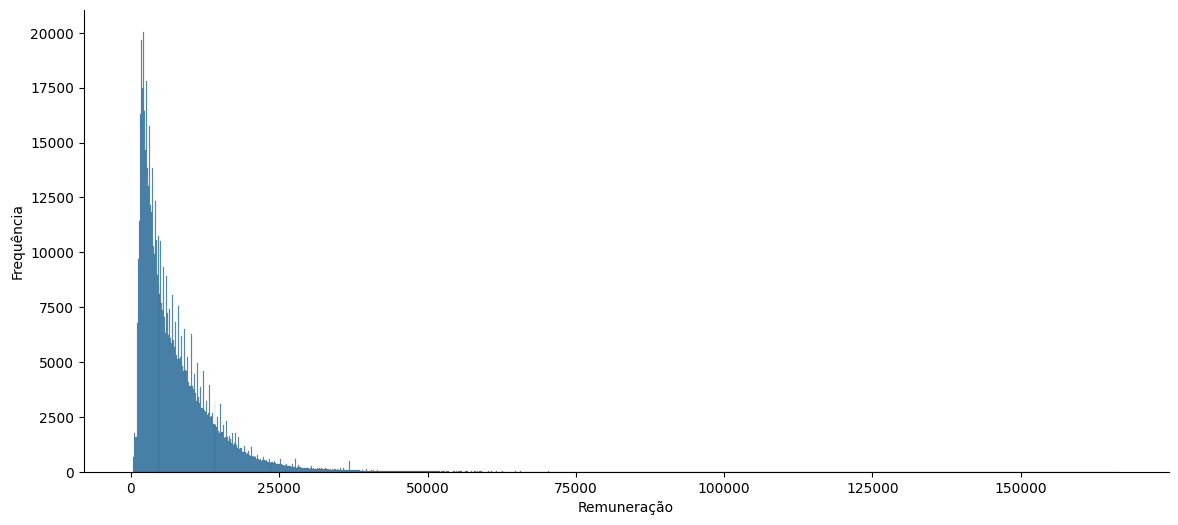

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)

hist = sns.histplot(RAIS_2021.Remuneração)
sns.despine()
hist.set_ylabel('Frequência')

fig.savefig("C:/Users/leila/estagio/data/figures/hist_remuneracao_geral_2021.svg")

Abaixo é exemplicado nos dados utilizados no trabalho esta desproporção de renda:

In [8]:
print("Soma dos salários dos trabalhadores 1% mais ricos: {}".format(RAIS_2021.Remuneração[RAIS_2021.Remuneração > RAIS_2021.Remuneração.quantile(0.99)].sum()))
print("Quantidade de trabalhadores 1% mais ricos: {}".format(RAIS_2021.Remuneração[RAIS_2021.Remuneração > RAIS_2021.Remuneração.quantile(0.99)].count()))

print()

print("Soma dos salários dos trabalhadores 27,9% mais pobres, aproximadamente: {}".format(RAIS_2021.Remuneração[RAIS_2021.Remuneração < RAIS_2021.Remuneração.quantile(0.2793)].sum()))
print("Quantidade de trabalhadores 27,9% mais pobres: {}".format(RAIS_2021.Remuneração[RAIS_2021.Remuneração < RAIS_2021.Remuneração.quantile(0.2793)].count()))

Soma dos salários dos trabalhadores 1% mais ricos: 334714009.4894745
Quantidade de trabalhadores 1% mais ricos: 6804

Soma dos salários dos trabalhadores 27,9% mais pobres, aproximadamente: 389475945.9790977
Quantidade de trabalhadores 27,9% mais pobres: 190010


Logo, o salário somado de todas as 3.914 pessoas mais ricas em funções trabalhistas de TI é aproximadamente de 200 milhões de reais. Enquanto são necessárias 110.015 pessoas de menor renda para, no total, termos o equivalente salarial dos 1% mais ricos, demonstrando que a desigualdade de renda é observada, não somente no país ao todo, mas também nas ocupações de TI.

Para garantir que a distribuição não é normal, é necessário realizar alguns testes de normalidade. Isto é importante para mais a frente ser possível comparar as médias (dos salários entre sexos) corretamente. Caso seja uma normal, são utilizados testes específicos para a comparação, caso não seja normal, deve-se utilizar a abordagem não paramétrica.

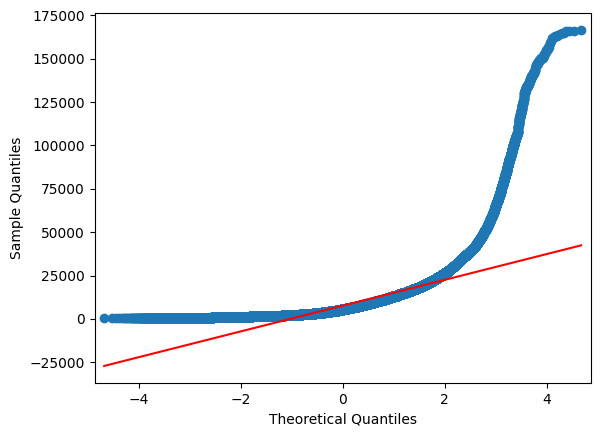

In [9]:
qqplot(RAIS_2021.Remuneração, line='s')
plt.show()

Teste de normalidade para concluir estatísticamente de que a distribuição da variável remuneração não é normal:

In [10]:
# Realização do teste de Shapiro considerando o nível de confiança de 0.01:

stat, p_valor = shapiro(RAIS_2021.sample(5000).Remuneração)
print('Estatística Shapiro = {:.5f}, p-valor = {:.5f}'.format(stat, p_valor))

if p_valor > nivel_confianca:
    print('A amostra parece ser Gaussiana (falha ao rejeitar H0)')
else:
    print('A amostra não parece ser Gaussiana (rejeitar H0)')

Estatística Shapiro = 0.70090, p-valor = 0.00000
A amostra não parece ser Gaussiana (rejeitar H0)


Para garantir a conclusão, abaixo é realizado outro teste de normalidade:

In [11]:
# Realização do teste de normalidade:

stat, p_valor = normaltest(RAIS_2021.Remuneração)
print('Estatística = {:.5f}, p-valor = {:.5f}'.format(stat, p_valor))

if p_valor > nivel_confianca:
    print('A amostra parece ser Gaussiana (falha ao rejeitar H0)')
else:
    print('A amostra não parece ser Gaussiana (rejeitar H0)')

Estatística = 636338.31516, p-valor = 0.00000
A amostra não parece ser Gaussiana (rejeitar H0)


### Análise da frequência (quantidade de pessoas) dos dados entre homens e mulheres:

In [12]:
# Pegando a quantidade de homens e mulheres nos dados:

qnt_masculino = RAIS_2021_masculino.Remuneração.count()
qnt_feminino = RAIS_2021_feminino.Remuneração.count()

print("Quantidade trabalhadores masculinos: {}.\n" \
      "Quantidade trabalhadores femininos: {}.\n" \
      "São aproximadamente {:.2f} mais homens que mulheres.".format(qnt_masculino, qnt_feminino, qnt_masculino / qnt_feminino))


Quantidade trabalhadores masculinos: 540380.
Quantidade trabalhadores femininos: 139952.
São aproximadamente 3.86 mais homens que mulheres.


No gráfico abaixo é possível visualizar de forma geral tal distribuição:

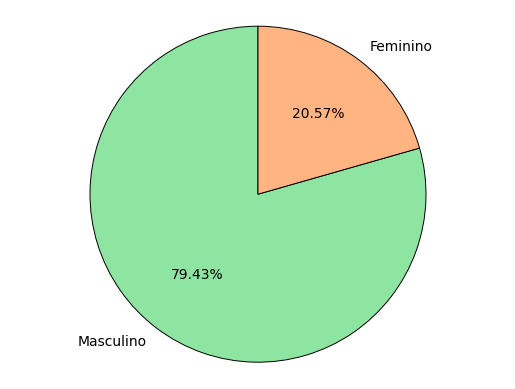

In [13]:
freq_fig, freq_ax = plt.subplots()
freq_ax.pie([qnt_masculino, qnt_feminino], labels = ("Masculino", "Feminino"), 
            autopct = '%1.2f%%', startangle = 90, colors = (color_masc, color_fem),
            wedgeprops={"edgecolor":"0",'linewidth': 0.7, 'antialiased': True})
freq_ax.axis('equal')

freq_fig.savefig("C:/Users/leila/estagio/data/figures/svg/qnt_sexo_pie_geral_2021.svg")

### Análise da massa salarial de homens e mulheres:

In [14]:
# Pegando a massa salarial de homens e mulheres nos dados:

massa_salarial_masculino = RAIS_2021_masculino.Remuneração.sum()
massa_salarial_feminino = RAIS_2021_feminino.Remuneração.sum()

print("Massa salarial trabalhadores masculinos: {:.2f}.\n" \
      "Massa salarial trabalhadores femininos: {:.2f}.\n" \
      "A massa salarial dos homens é {:.2f} vezes maior que das mulheres.".format(massa_salarial_masculino, massa_salarial_feminino, massa_salarial_masculino / massa_salarial_feminino))

Massa salarial trabalhadores masculinos: 4208288738.55.
Massa salarial trabalhadores femininos: 979288532.87.
A massa salarial dos homens é 4.30 vezes maior que das mulheres.


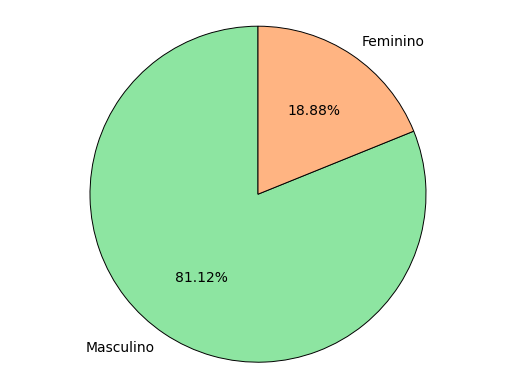

In [15]:
freq_fig, freq_ax = plt.subplots()
freq_ax.pie([massa_salarial_masculino, massa_salarial_feminino], labels = ("Masculino", "Feminino"), 
            autopct = '%1.2f%%', startangle = 90, colors = (color_masc, color_fem),
            wedgeprops={"edgecolor":"0",'linewidth': 0.7, 'antialiased': True})
freq_ax.axis('equal')

freq_fig.savefig("C:/Users/leila/estagio/data/figures/svg/massa_sexo_pie_geral_2021.svg")

### Análise das médias salariais e diferenças:

C:\Users\leila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\leila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\leila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Categoric

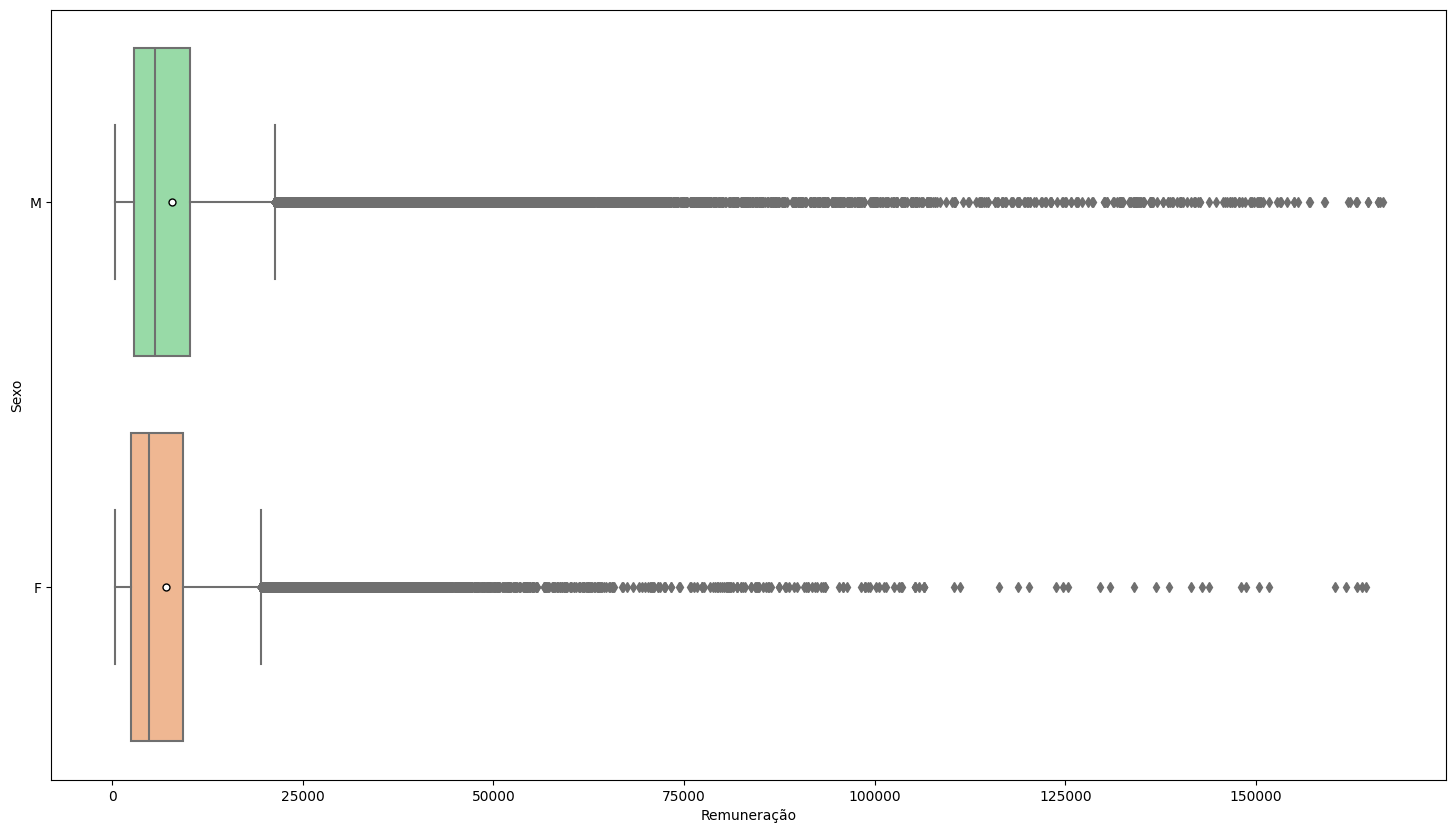

In [16]:
RAIS_2021["Sexo"].replace(sexo, inplace = True)

box = sns.boxplot(x = 'Remuneração', y = 'Sexo', data = RAIS_2021, orient = 'h', 
                  showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", 
                  "markeredgecolor":"black", "markersize":"5"},
                  palette = {"M": color_masc, "F": color_fem})
box.figure.set_size_inches(18, 10)

box.figure.savefig("C:/Users/leila/estagio/data/figures/png/boxplot_geral_2021.png", dpi = 300)

In [17]:
# Capturando as médias e medianas

media_masculino = RAIS_2021_masculino.Remuneração.mean()
mediana_masculino = RAIS_2021_masculino.Remuneração.median()

media_feminino = RAIS_2021_feminino.Remuneração.mean()
mediana_feminino = RAIS_2021_feminino.Remuneração.median()

# Exibindo os dados: 

print("Masculino:")
print("Média das remunerações: R$ {:.2f}\n" \
      "Mediana das remunerações: R$ {:.2f}".format(media_masculino, mediana_masculino))

print()

print("Feminino:")
print("Média das remunerações: R$ {:.2f}\n" \
      "Mediana das remunerações: R$ {:.2f}".format(media_feminino, mediana_feminino))

print()

# Tirando os percentuais de diferença:

dif_salarial_media = media_masculino - media_feminino
taxa_dif_media = ((media_feminino - media_masculino) / media_masculino) * 100

dif_salarial_mediana = mediana_masculino - mediana_feminino
taxa_dif_mediana = ((mediana_feminino - mediana_masculino) / mediana_masculino) * 100

print("Diferença salarial média: R$ {:.2f}\n" \
      "Variação percentual média: {:.2f} %\n".format(dif_salarial_media, taxa_dif_media))

print("Diferença salarial mediana: R$ {:.2f}\n" \
      "Variação percentual mediana: {:.2f} %".format(dif_salarial_mediana, taxa_dif_mediana))

Masculino:
Média das remunerações: R$ 7787.65
Mediana das remunerações: R$ 5578.87

Feminino:
Média das remunerações: R$ 6997.32
Mediana das remunerações: R$ 4880.26

Diferença salarial média: R$ 790.33
Variação percentual média: -10.15 %

Diferença salarial mediana: R$ 698.62
Variação percentual mediana: -12.52 %


Para afirmar que estatisticamente estes dados são comparáveis, é necessário realizar um teste de hipótese entre os dois grupos, comparando se as médias realmente menores uma que a outra.

### Teste de hipótese para as mediana:

Para testar se a mediana das mulheres é estatisticamente menor que a mediana dos homens, será utilizado o teste não paramétrico de Mann-Whitney, visto que os grupos não são pareados, ou seja, são grupos que não dependem um do outro.

In [18]:
stat, p_valor = mannwhitneyu(RAIS_2021_feminino.Remuneração, RAIS_2021_masculino.Remuneração, alternative = 'less')

print("Estatística Mann-Whitney = {:.2f}, p-valor = {:.15f}".format(stat, p_valor))

if p_valor <= nivel_confianca:
    print('A mediana salarial das mulheres é menor que a mediana dos homens (rejeitar H0)')
else:
    print('As medianas não são diferentes (falha ao rejeitar H0)')

Estatística Mann-Whitney = 34801696998.50, p-valor = 0.000000000000000
A mediana salarial das mulheres é menor que a mediana dos homens (rejeitar H0)


Ao rejeitar a hipótese nula do teste Mann-Whitney, da qual aponta que não há diferenças entra as medianas, podemos inferir estatisticamente que a mediana salarial feminina é menor que a mediana salarial masculina, demonstrando de que as diferenças são estatisticamente possíveis e sustentando a possível realidade entre esta diferença salarial.